In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csic-2010-web-application-attacks/csic_database.csv


2025-06-27 12:41:55.571371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751028115.862265      14 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751028115.942557      14 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-27 12:42:16.731663: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training Bi-LSTM
382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step
Bi-LSTM - Accuracy: 0.9870, F1: 0.9841, Precision: 0.9976, Recall: 0.9710, Log Loss: 0.0478

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7148
      Attack       1.00      0.97      0.98      5065

    accuracy                           0.99     12213
   macro avg       0.99      0.98      0.99     12213
weighted avg       0.99      0.99      0.99     12213



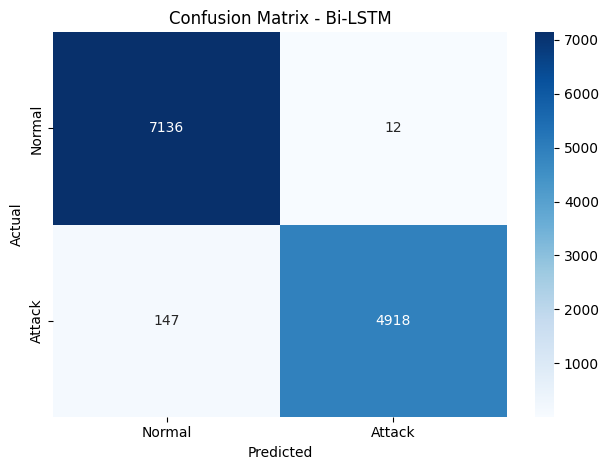


Training Bi-GRU
382/382 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step
Bi-GRU - Accuracy: 0.9856, F1: 0.9824, Precision: 0.9976, Recall: 0.9676, Log Loss: 0.0592

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7148
      Attack       1.00      0.97      0.98      5065

    accuracy                           0.99     12213
   macro avg       0.99      0.98      0.99     12213
weighted avg       0.99      0.99      0.99     12213



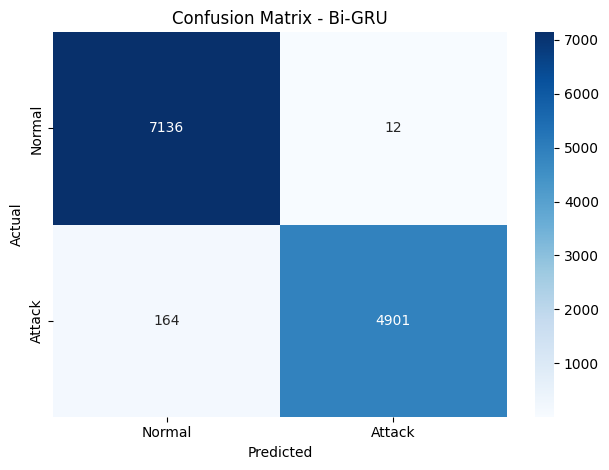


Training 1D-CNN
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
1D-CNN - Accuracy: 0.9877, F1: 0.9850, Precision: 0.9984, Recall: 0.9720, Log Loss: 0.0484

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7148
      Attack       1.00      0.97      0.98      5065

    accuracy                           0.99     12213
   macro avg       0.99      0.99      0.99     12213
weighted avg       0.99      0.99      0.99     12213



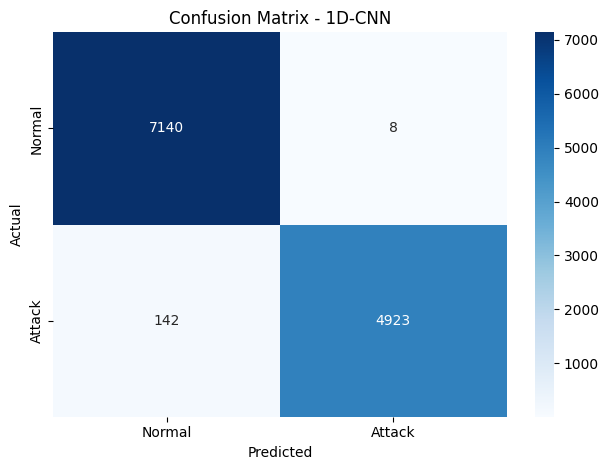


Training Transformer
382/382 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step
Transformer - Accuracy: 0.9857, F1: 0.9825, Precision: 0.9965, Recall: 0.9688, Log Loss: 0.0583

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7148
      Attack       1.00      0.97      0.98      5065

    accuracy                           0.99     12213
   macro avg       0.99      0.98      0.99     12213
weighted avg       0.99      0.99      0.99     12213



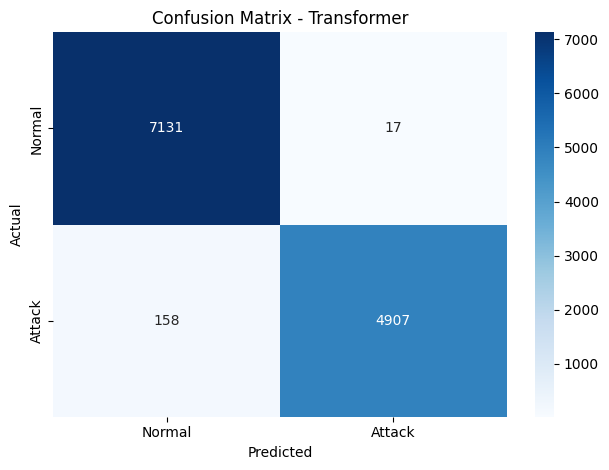


Performance Summary:
      Model  Accuracy  F1 Score  Precision   Recall  Log Loss
     1D-CNN  0.987718  0.984994   0.998378 0.971964  0.048358
    Bi-LSTM  0.986981  0.984092   0.997566 0.970977  0.047841
Transformer  0.985671  0.982481   0.996548 0.968806  0.058317
     Bi-GRU  0.985589  0.982361   0.997558 0.967621  0.059220


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, log_loss, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout, Bidirectional,
    Conv1D, GlobalMaxPooling1D, Input, MultiHeadAttention,
    LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and Prepare Data
file_path = "/kaggle/input/csic-2010-web-application-attacks/csic_database.csv"
df = pd.read_csv(file_path)

df["text"] = (
    df["Method"].fillna("") + " " +
    df["URL"].fillna("") + " " +
    df["content"].fillna("") + " " +
    df["User-Agent"].fillna("")
)

X = df["text"].values
y = df["classification"].values  # 0 = Normal, 1 = Attack

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Tokenization and Padding
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# 4. Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 5. Model Definitions
def build_lstm_model():
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.build(input_shape=(None, max_len))
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model():
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        Bidirectional(GRU(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(GRU(32)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.build(input_shape=(None, max_len))
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model():
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.build(input_shape=(None, max_len))
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_transformer_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=128)(inputs)

    attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = Dense(128, activation='relu')(x)
    ffn_output = Dropout(0.2)(ffn_output)
    x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])  # Slower LR for transformer
    model.build(input_shape=(None, max_len))
    return model

# 6. Train and Evaluate All Models
models = {
    "Bi-LSTM": build_lstm_model(),
    "Bi-GRU": build_gru_model(),
    "1D-CNN": build_cnn_model(),
    "Transformer": build_transformer_model()
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}")
    history = model.fit(
        X_train_pad, y_train,
        epochs=10, batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_prob = model.predict(X_test_pad)
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_prob)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Log Loss": loss
    })

    print(f"{name} - Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Log Loss: {loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# 7. Final Comparison
results_df = pd.DataFrame(results).sort_values("F1 Score", ascending=False)
print("\nPerformance Summary:")
print(results_df.to_string(index=False))
